In [11]:
### Import all libraries and define various parameters here!
import numpy as np
from numpy import linalg as LA
import math
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline

### dissipation parameters for electronic and photonic system
gam_diss_np = 0.000005
gam_deph_np = 0.0000

gam_diss_m = 0.00000
gam_deph = 0.0000

### energy of photonic and molecular system
#en_hnp = 0.075
#en_mol = 0.075

### array of dissipation parameters to be passed to RK4 function
gamma = np.zeros(4)
gamma[0] = 0.
gamma[1] = gam_diss_np
gamma[2] = gam_diss_m
gamma[3] = gam_diss_m+gam_diss_np

### Number of updates for dynamics
N_time = 500000

### Initial position, velocity, timestep, and R-step for dynamics
ri = -0.7
vi = 0.0001282*1.5
dr = 0.1
dt = 0.75

### This is the reduced mass of this rotational mode for the dynamics
M = 1009883


### hbar omega_c in atomic units
omc = 2.18/27.211 
### hbar g_c in atomic units
gc = 0.136/27.211

### Htot
He = np.zeros((4,4))
Hp = np.zeros((4,4))
Hep = np.zeros((4,4))
Htot = np.zeros((4,4))

### various arrays for dynamics
time = np.zeros(N_time)
r_of_t = np.zeros(N_time)
v_of_t = np.zeros(N_time)
e_of_t = np.zeros(N_time)
p_of_t = np.zeros((N_time,4))


Following Mandal and Huo in their J. Phys. Chem. Lett. paper [here](https://pubs.acs.org/doi/abs/10.1021/acs.jpclett.9b01599), we will define the polariton Hamiltonian as follows:

\begin{equation}
\hat{H}_{pl} = \hat{H}_{el} + \hat{H}_p + \hat{H}_{el,p}
\end{equation}

where $\hat{H}_e$ denotes the electronic Hamiltonian:
\begin{equation}
\hat{H}_{el} = E_g(R) \: \hat{a}^{\dagger}_g \hat{a}_g + E_e(R) \: \hat{a}^{\dagger}_e \hat{a}_e,
\end{equation}
where $E_g(R)$ ($E_e(R)$) denotes the ground- (excited-) state electronic energy at nuclear coordinate $R$, and
$\hat{a}^{\dagger}_p$ ($\hat{a}_p$) are the creation (annihilation) operators for electronic state $p$.
The following matrix elements are equal to 1 using these operators and the basis states spanning $|g\rangle , |e\rangle$.
\begin{align}
\langle g | \hat{a}^{\dagger}_g \hat{a}_g | g \rangle = 1 \\
\langle e | \hat{a}^{\dagger}_e \hat{a}_e | e \rangle = 1 \\
\langle g | \hat{a}^{\dagger}_g \hat{a}_e | e \rangle = 1 \\
\langle e | \hat{a}^{\dagger}_e \hat{a}_g | g \rangle = 1; 
\end{align}
all other are zero.


The photon Hamiltonian is 
\begin{equation}
\hat{H}_p = \hbar \omega_c \left(\hat{b}^{\dagger} \hat{b} + \frac{1}{2}  \right),
\end{equation}
where $\hat{b}^{\dagger}$ and $\hat{b}$ denote the raising/lowering operators for the photon states, respectively.
The raising operator has the general effect on the basis states $|n\rangle$,
\begin{equation}
\hat{b}^{\dagger} |n\rangle = \sqrt{n+1} |n+1\rangle,
\end{equation}
while the lowering operator has the general effect
\begin{equation}
\hat{b} |n\rangle = \sqrt{n} |n-1\rangle;
\end{equation}
importantly, $\hat{b} |0\rangle  = 0$.  Both the photon and the electronic basis states form an orthonormal 
set, such that
\begin{equation}
\langle i | j \rangle = \delta_{ij}.
\end{equation}

Following Eq. S2 from Mandal and Huo, we compute $E_g(R)$ and $E_e(R)$ using the following code (see S2 in [this document](https://pubs.acs.org/doi/suppl/10.1021/acs.jpclett.9b01599/suppl_file/jz9b01599_si_001.pdf) for explicit equations):

In [12]:
### Function to return the ground and excited-state electronic energy as a function of
### the nuclear coordinate $R$
def E_of_R(R):
    Ai = np.array([0.049244, 0.010657, 0.428129, 0.373005])
    Bi = np.array([0.18, 0.18, 0.18, 0.147])
    Ri = np.array([-0.75, 0.85, -1.15, 1.25])
    Di = np.array([0.073, 0.514])
    
    v = Ai + Bi*(R - Ri)**2
    
    Eg = 0.5*(v[0] + v[1]) - np.sqrt(Di[0]**2 + 0.25 * (v[0] - v[1])**2)
    Ee = 0.5*(v[2] + v[3]) - np.sqrt(Di[1]**2 + 0.25 * (v[2] - v[3])**2)
    return [Eg, Ee]
    

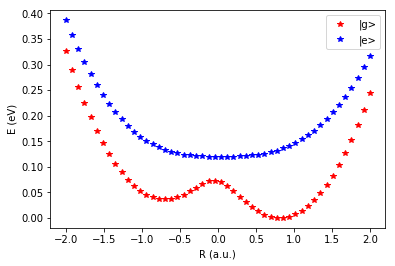

In [13]:
### Code to run E_of_R function for a variety of values of R between -1.5 and 1.5 atomic units
### and plot the energy in electron volts for the ground- and excited-state surface, 
### giving the plot from Figure 2 of Mandal and Huo's paper
rlist = np.linspace(-2.0, 2.0, 50)

E_ground = []
E_excite = []
for r in rlist:
    PES = E_of_R(r)
    E_ground.append(PES[0])
    E_excite.append(PES[1])
    
plt.plot(rlist, E_ground, 'r*', label='|g>')
plt.plot(rlist, E_excite, 'b*', label='|e>')
plt.xlabel("R (a.u.)")
plt.ylabel("E (eV)")
plt.legend()
plt.show()

The energy as a function of $R$ on the electronic ground $|g\rangle$ and excited-state $|e\rangle$ are referred
to as potential energy surfaces, $E_g(R)$ and $E_e(R)$, respectively.  The forces experienced by the nuclei as a function of position when the molecule is purely in the electronic ground state is given by 
\begin{equation}
F_g(R) = -\frac{\partial E_g(R)}{\partial R} \equiv -\frac{\partial }{\partial R} \langle g |  \hat{H}_{el} | g \rangle,
\end{equation}
and similarly, when the molecule is purely in the electronic excited-state, the force is given by 
\begin{equation}
F_e(R) = -\frac{\partial E_e(R)}{\partial R} \equiv -\frac{\partial }{\partial R} \langle e |  \hat{H}_{el} | e \rangle.
\end{equation}
When the system is in a superposition, $|\Psi \rangle = c_g |g\rangle + c_e |e\rangle$, the situation becomes more difficult in terms of defining the force.  One prescription for computing the Force and resulting dynamics is known 
as *Ehrenfest dynamics*, and can be seen as a weighted average of the forces experienced by the system from its ground- and excited-state contributions:
\begin{align}
F_{Eh} = -\frac{\partial }{\partial R} \langle \Psi |  \hat{H}_{el} | \Psi \rangle \\
F_{Eh} = -\frac{\partial }{\partial R} c_g^* c_g \langle g |  \hat{H}_{el} | g \rangle \\
-\frac{\partial }{\partial R} c_g^* c_e \langle g |  \hat{H}_{el} | e \rangle \\
-\frac{\partial }{\partial R} c_e^* c_g \langle e |  \hat{H}_{el} | g \rangle \\
- \frac{\partial }{\partial R} c_e^* c_e \langle e |  \hat{H}_{el} | e \rangle.
\end{align}
We note that when using the eigenstates of the electronic Hamiltonian ($|g\rangle$ and $|e\rangle$), 
the cross terms above vanish, but this will not be true when the full polaritonic Hamiltonian is used 
since the ground- and excited electronic states are coupled through polaritonic terms.

Once the force is known, the acceleration may be computed from Newton's law:
\begin{equation}
F(R) = M \frac{d^2 R(t)}{dt^2} \rightarrow \ddot{R}(t)= \frac{F(R)}{M},
\end{equation}
where $\ddot{R}(t)$ indicates the second derivative of $R$ with respect to time, i.e. the
acceleration along the reaction coordinate $R$.

With the acceleration computed from the force, position, and velocity 
along the reaction coordinate at some instant in 
time $t_i$ can be updated at some later time $t_{i+1} = t_i + \Delta t$ as follows:
\begin{equation}
R(t_i + \Delta t) = R(t_i) + \dot{R}(t_i)\Delta t + \frac{1}{2}\ddot{R}(t_i)\Delta t^2
\end{equation}
and
\begin{equation}
\dot{R}(t_i + \Delta t) = \dot{R}(t_i) + \frac{1}{2} \left(\ddot{R}(t_i) + \ddot{R}(t_i + \Delta t)  \right) \Delta t,
\end{equation}
where again the notation $\dot{R}$ indicates the first derivative of $R$ with respect to time.

### Fit a cubic spline to both PESs above so that the forces can easily be computed at any value of R

### Implement the Velocity-Verlet Algorithm to update position and velocity; using M = 1009883. atomic units (make sure R and E and F are in atomic units!!!!)

### Determine REASONABLE initial conditions for position and velocity

### Run several trajectories on the ground and the excited-state PES using different initial conditions just to gain some intuition for how these trajectories go.

### Determine a scheme for incorporating Liouville-Lindblad dynamics of electronic degrees of freedom into Ehrenfest dynamics

Rough Outline for coupled Liouville-Lindblad dynamics:

Electronic Density Matrix evolves according to
\begin{equation}
\frac{d}{dt} {\bf D}(t) = \frac{-i}{\hbar} [{\bf H},{\bf D}(t)] + \hat{L}({\bf D}(t)).
\end{equation}
where here ${\bf H}$ is just a diagonal matrix with the following form:
\begin{equation}
{\bf H}
  \mbox{=}
  \begin{pmatrix}
    E_g(R)   &     0   \\
    0        &     E_e(R)  
  \end{pmatrix}
\end{equation}
and 
\begin{equation}
\hat{L}({\bf D}(t)) =  2\gamma \langle e | {\bf D}(t) | e \rangle | g \rangle \langle g | - 
\gamma \{ |e\rangle \langle e|, {\bf D}(t) \}.
\end{equation}
The Lindblad operator $\hat{L}({\bf D}(t))$ accounts for the relaxation from the excited-state $|e\rangle$ to
the ground-state $|g\rangle$ with a rate $\gamma$.  **Note: we need to determine a reasonable value of $\gamma$!**
The elements of the density matrix will take on the form
\begin{equation}
D_{ij} = c_i c_j^*
\end{equation}
where $c_i$ are the expansion coefficients for $\Psi$ and $c_j^*$ are their complex conjugates.  




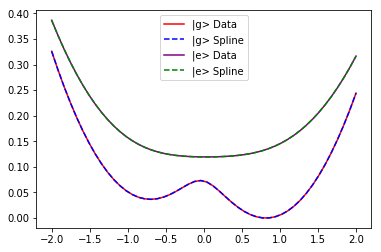

In [14]:
### form spline for ground-state surface
Eg_spline = InterpolatedUnivariateSpline(rlist, E_ground, k=3)
Fg_spline = Eg_spline.derivative()

### form spline for excited-state surface
Ee_spline = InterpolatedUnivariateSpline(rlist, E_excite, k=3)
Fe_spline = Ee_spline.derivative()


#Eg_spline = interpolate.splrep(rlist, E_ground, s=0)
#Fg_spline = interpolate.splev(rlist, Eg_spline, der=1)

#print(Eg_spline)
plt.plot(rlist, E_ground, 'red', label='|g> Data')
plt.plot(rlist, Eg_spline(rlist), 'b--', label='|g> Spline')
plt.plot(rlist, E_excite, 'purple', label='|e> Data')
plt.plot(rlist, Ee_spline(rlist), 'g--', label='|e> Spline')
### if you want to soom in on the left-hand-well of |g> surface, uncomment below
#plt.xlim(-0.8,-0.6)
#plt.ylim(0.035,0.04)
plt.legend()
plt.show()

If we take the initial position to correspond to the left well on the ground-state PES ($R ~ -0.7$), then we can estimate the initial velocity from the curvature of the PES at that position:
\begin{equation}
k = \frac{\partial ^2}{\partial R^2} E_g(R = -0.7),
\end{equation}
which we may compute using the derivative capability of the cubic splines fit.  In particular
this will be the first derivative of the force spline for the ground state.

In [15]:
### get the curvature spline for the ground state
Cg_spline = Fg_spline.derivative()
### get the force constant by evaluating the curvature spline at R = -0.7 
k_g = Cg_spline(-0.7)
print(" Force constant of left well on |g> surface is",k_g)

 Force constant of left well on |g> surface is 0.31246871517560126


If we use the harmonic oscillator approximation in conjunction with the virial theorem, 
then we can arrive at the following expression for the expectation value of velocity:
\begin{equation}
\langle v \rangle = \sqrt{\frac{\hbar \sqrt{\frac{k}{\mu}}}{2\mu}}.
\end{equation}

In [5]:
#### Uncomment if you wish to use this scheme to approximate the velocity
### This is the reduced mass of this rotational mode
#M = 1009883
#### This is R_eq on the left well of |g>
#ri = -0.7
#vi = np.sqrt( np.sqrt(k_g/M) / (2*M))
#print("vi is ",vi)


vi is  1.6595232506809012e-05


In [16]:
### should create a function that takes a wavefunction in vector
### format and computes a density matrix
def Form_Rho(Psi):

    D = np.outer(Psi,np.conj(Psi))
    return D

def RK4(H, D, h, gamma, gam_deph):
    k1 = np.zeros_like(D)
    k2 = np.zeros_like(D)
    k3 = np.zeros_like(D)
    k4 = np.zeros_like(D)
    D1 = np.zeros_like(D)
    D2 = np.zeros_like(D)
    D3 = np.zeros_like(D)
    D4 = np.zeros_like(D)
    
    ### Get k1
    D1 = np.copy(D)    
    k1 = h*DDot(H,D1) + h*L_Diss(D1, gamma) + h*L_Deph(D1, gam_deph)
    
    ### Update H and D and get k2
    D2 = np.copy(D+k1/2.)
    k2 = h*DDot(H, D2) + h*L_Diss(D2, gamma) + h*L_Deph(D2, gam_deph)
    
    ### UPdate H and D and get k3
    D3 = np.copy(D+k2/2)
    k3 = h*DDot(H, D3) + h*L_Diss(D3, gamma) + h*L_Deph(D3, gam_deph)
    
    ### Update H and D and get K4
    D4 = np.copy(D+k3)
    k4 = h*DDot(H, D4) + h*L_Diss(D4, gamma) + h*L_Deph(D4, gam_deph)
    
    Df = D + (1/6.)*(k1 + 2.*k2 + 2*k3 + k4)
    return Df

### Lindblad operator that models dephasing
def L_Deph(D, gam):
    dim = len(D)
    LD = np.zeros_like(D)
    
    for k in range(1,dim):
        bra_k = CreateBas(dim, k)
        km = Form_Rho(bra_k)
        
        ### first term 2*gam*<k|D|k>|k><k|
        t1 = 2*gam*D[k][k]*km
        ### second term is |k><k|*D
        t2 = np.dot(km,D)
        ### third term is  D*|k><k|
        t3 = np.dot(D, km)
        LD = LD + t1 - gam*t2 - gam*t3
        
    return LD

### Creates basis vector for state k
### k=0 -> ground state, k=1 -> first excited-state, etc
def CreateBas(dim, k):
    bas = np.zeros(dim)
    bas[k] = 1
    return bas

### Lindblad operator that models relaxation to the ground state
def L_Diss(D, gamma):
    dim = len(D)
    LD = np.zeros_like(D)
    ### need |g><g|
    bra_1 = CreateBas(dim, 0)
    gm = Form_Rho(bra_1)
    
    for k in range(1,dim):
        gam = gamma[k]
        bra_k = CreateBas(dim, k)
        km = Form_Rho(bra_k)
        
        ### first term 2*gam*<k|D|k>|g><g|
        t1 = 2*gam*D[k][k]*gm
        ### second term is |k><k|*D
        t2 = np.dot(km,D)
        ### third term is  D*|k><k|
        t3 = np.dot(D, km)
        LD = LD + t1 - gam*t2 - gam*t3
        
    return LD

def DDot(H, D):
    ci = 0.+1j
    return -ci*(np.dot(H,D) - np.dot(D, H))

def TrHD(H, D):
    N = len(H)
    HD = np.dot(H,D)
    som = 0
    for i in range(0,N):
        som = som + HD[i,i]
    return np.real(som)

Let's create a more general propagator for Ehrenfest dynamics that first uses finite differences of the expectation value of the electronic energy to get the Force, then makes the partial nuclear update, updates the electronic density matrix and computes the forces at the partial update, then completes the nuclear update.

The contribution from photons and photon-molecule interactions can give rise to polaritonic dynamics.  The interaction Hamiltonian has the form
\begin{equation}
\hat{H}_{el,p} = \hbar g_c \left(\hat{b}^{\dagger} + \hat{b}\right)
\left(\hat{a}^{\dagger}_e \hat{a}_g + \hat{a}^{\dagger}_g \hat{a}_e \right).
\end{equation}
Considering the following four basis states: $|g\rangle |0\rangle, |g\rangle |1\rangle, 
|e\rangle |0\rangle, |e\rangle |1\rangle$, we can identify the following contributions to the total Hamiltonian matrix:

\begin{equation}
{\bf H}_{el}
  \mbox{=}
  \begin{pmatrix}
    E_g(R)   &     0   & 0 & 0 \\
    0        &   E_g(R) & 0 & \\
    0        &    0  & E_e(R) & 0 \\
    0        &    0   &  0  & E_e(R) 
  \end{pmatrix}
\end{equation}

\begin{equation}
{\bf H}_{p}
  \mbox{=}
  \begin{pmatrix}
    \frac{1}{2} \hbar \omega_c  &     0 &     0 &     0   \\
    0        &     \frac{3}{2} \hbar \omega_c &     0 &     0  \\
    0        &       0  & \frac{1}{2} \hbar \omega_c  & 0 \\
    0        &     0    &     0  &     \frac{3}{2} \hbar \omega_c 
  \end{pmatrix}
\end{equation}

\begin{equation}
{\bf H}_{el,p}
  \mbox{=}
  \begin{pmatrix}
    0   &     0  & 0 & 0 \\
    0   &     0  & \hbar g_c & 0  \\
    0   & \hbar g_c   &    0  &  0 \\
    0   &     0  & 0 & 0
  \end{pmatrix}
\end{equation}
so that the total Hamiltonian has the form


\begin{equation}
{\bf H}_{Tot}
  \mbox{=}
  \begin{pmatrix}
  E_g(R) + \frac{1}{2} \hbar \omega_c   &     0  & 0 & 0 \\
    0        & E_g(R) + \frac{3}{2} \hbar \omega_c  &     \hbar g_c & 0  \\
    0 & \hbar g_c        &    E_e(R) + \frac{1}{2} \hbar \omega_c & 0 \\
    0   &     0  & 0 & E_e(R) + \frac{3}{2} \hbar \omega_c
  \end{pmatrix}.
\end{equation}

Consider the case where $\hbar \omega_c = 2.18 \: eV$ and $\hbar g_c = 0.136 \: eV$; *express these quantities in atomic units!*

The new *polaritonic* potential energy surfaces can be identified by building ${\bf H}_{Tot}$ at differnt values of $R$, diagonalizing the matrix, and identifying the eigenvalues.  We will denote the lowest eigenvalue as a function of $R$ as the lower polariton surface and the largest eigenvalue as a function of $R$ as the upper polariton surface.


In [30]:
### Forms the electronic Hamiltonian matrix at a given value of the nuclear coordinate
### FOR 4x4 case relevant for 1-mode polariton case
def H_e(Hmat, R):
    PES = E_of_R(R)
    Hmat[0,0] = PES[0]
    Hmat[1,1] = PES[0]
    Hmat[2,2] = PES[1]
    Hmat[3,3] = PES[1]
    return Hmat

### Form bare photon hamiltonian with frequency omega c for 4x4 case 
### relevant for 1-mode polariton case
def H_p(Hmat, omega):
    Hmat[0,0] = 0.5 * omega
    Hmat[1,1] = 1.5 * omega
    Hmat[2,2] = 0.5 * omega
    Hmat[3,3] = 1.5 * omega
    return Hmat

### form coupling hamiltonian with coupling strength gamma_c for 4x4 
### case relevant for 1-mode polariton case
def H_ep(Hmat, g):
    Hmat[1,2] = g
    Hmat[2,1] = g
    return Hmat

### Transform density matrix from local to polariton basis
### at a given R... return (diagonal) polariton Hamiltonian
### and transformation vecs, also
def Transform_L_to_P(r, Dl, Hp, Hep):
    He = np.zeros((4,4))
    He = H_e(He, r)
    Htot = He + Hp + Hep
    ### get eigenvalues/vectors of total Hamiltonian at this R
    vals, vecs = LA.eig(Htot)
    ### sort the eigenvectors
    idx = vals.argsort()[::1]
    vals = vals[idx]
    v = vecs[:,idx]
    ### transform Htot with v^-1
    vt0 = np.dot(LA.inv(v),Htot)
    ### finish transformation to polariton basis, Hpl
    Hpl = np.dot(vt0,v)
    ### now do transformation for density matrix from local to polariton basis
    dt0 = np.dot(LA.inv(v), Dl)
    Dpl = np.dot(dt0,v)
    ### return Hpl and Dpl
    return [Hpl, Dpl, v]

### Transform density matrix from polariton to local basis
### at a given R... return (off-diagonal) local Hamiltonian
### and transformation vecs, also
def Transform_P_to_L(r, Dp, Hp, Hep):
    He = np.zeros((4,4))
    He = H_e(He, r)
    Htot = He + Hp + Hep
    ### get eigenvalues/vectors of total Hamiltonian at this R
    vals, vecs = LA.eig(Htot)
    ### sort the eigenvectors
    idx = vals.argsort()[::1]
    vals = vals[idx]
    v = vecs[:,idx]
    ### now do transformation for density matrix from local to polariton basis
    dt0 = np.dot(v, Dp)
    Dl = np.dot(dt0,LA.inv(v))
    ### return Hpl and Dpl
    return [Htot, Dl, v]


def Erhenfest(r_curr, v_curr, mass, D, Hp, Hep, Hel, gamma, gam_deph, dr, dt):

    ''' Electronic part 1 '''
    ### Get forward-displaced electronic Hamiltonian
    Hel = H_e(Hel, r_curr+dr)
    Hf = Hp + Hep + Hel
    ### Get forward-dispaced density matrix
    D = RK4(Hf, D, dt, gamma, gam_deph)
    ### Get forward-displaced energy
    Ef = TrHD(Hf, D)
    ### Get back-displaced electronic Hamiltonian
    Hel = H_e(Hel, r_curr-dr)
    Hb = Hp + Hep + Hel
    D = RK4(Hb, D, dt, gamma, gam_deph)
    ### Get back-displaced energy
    Eb = TrHD(Hb, D)
    
    ''' Nuclear part 1'''
    ### Get force from finite-difference gradient
    F = (Eb - Ef)/(2*dr)
    ### Get acceleration from force
    a_curr = F / mass
    ### now get r in the future... r_fut
    r_fut = r_curr + v_curr*dt + 1/2 * a_curr*dt**2
    
    ''' Electronic part 2 '''
    ### now update electronic Hamiltonian
    Hel = H_e(Hel, r_fut+dr)
    Hf = Hp + Hep + Hel
    ### update electronic density matrix 
    D = RK4(Hf, D, dt, gamma, gam_deph)
    ### get forward-displaced energy
    Ef = TrHD(Hf,D)
    ### Get back-displaced electronic Hamiltonian
    Hel = H_e(Hel, r_curr-dr)
    Hb = Hp + Hep + Hel
    D = RK4(Hb, D, dt, gamma, gam_deph)
    #p_g = D[0,0]
    #p_e = D[1,1]
    #c_01 = D[0,1]
    #c_10 = D[1,0]
    ### Get back-displaced energy
    Eb = TrHD(Hb, D)
    
    ''' Nuclear part 2'''
    ### Get force from finite-difference gradient
    F = (Eb - Ef)/(2*dr)
    ### Get acceleration from force
    a_fut = F / mass
    v_fut = v_curr + 1/2 * (a_curr + a_fut)*dt
    ### return a list with new position and velocity
    return [r_fut, v_fut, D]

In [33]:
### Get the Hamiltonians that DON't depend on position... photonic and coupling
### note of course the coupling would really depend on R but we pretend it doesn't,
### and Huo et al. showed it doesn't have much of an impact...
Hp = H_p(Hp, omc)
Hep = H_ep(Hep, gc)
r = rlist[5]
He = H_e(He, r)
Htot = Hp+Hep+He
print(Htot)
D = np.zeros((4,4),dtype=complex)
D[2,2] = 1.+0j

[Hpl, Dpl, vec] = Transform_L_to_P(r, D, Hp, Hep)
print(Hpl)
print(Dpl)
print(vec)

Hl0 = np.dot(vec,Hpl)
Hl = np.dot(Hl0,LA.inv(vec))
print(Hl)
#def Transform_L_to_P(r, Dl, Hp, Hep):
Dp = np.zeros((4,4),dtype=complex)
Dp[2,2] = 1.+0j

[Hl, Dl, vec] = Transform_P_to_L(r, Dp, Hp, Hep)
print("Local Dl",Dl)

El = TrHD(Hl, Dl)

Ep = TrHD(Hpl, D)

print(" Local energy is ",El)
print(" polariton energy is ",Ep)

#def Transform_P_to_L(r, Dp, Hp, Hep):

[[0.21102823 0.         0.         0.        ]
 [0.         0.29114289 0.00499798 0.        ]
 [0.         0.00499798 0.3001173  0.        ]
 [0.         0.         0.         0.38023196]]
[[ 2.11028232e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.88913342e-01 -1.38777878e-17  0.00000000e+00]
 [ 0.00000000e+00  2.77555756e-17  3.02346854e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.80231964e-01]]
[[ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.16596924+0.j -0.37205302+0.j  0.        +0.j]
 [ 0.        +0.j -0.37205302+0.j  0.83403076+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]]
[[ 1.          0.          0.          0.        ]
 [ 0.          0.91325285  0.40739322  0.        ]
 [ 0.         -0.40739322  0.91325285  0.        ]
 [ 0.          0.          0.          1.        ]]
[[0.21102823 0.         0.         0.        ]
 [0.         0.291142

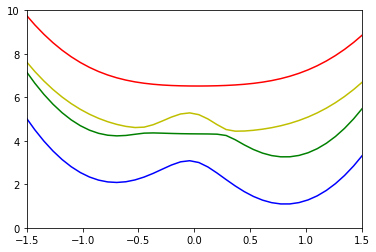

In [18]:
### Get the Hamiltonians that DON't depend on position... photonic and coupling
### note of course the coupling would really depend on R but we pretend it doesn't,
### and Huo et al. showed it doesn't have much of an impact...
Hp = H_p(Hp, omc)
Hep = H_ep(Hep, gc)
### form empty arrays for lower and upper polariton surface
PPES = np.zeros((len(rlist),4))
#### Get H_e(r) and diagonlize to get the polaritonic potential energy surfaces
for i in range(0,len(rlist)):
    r = rlist[i]
    He = H_e(He, r)
    Htot = He + Hp + Hep
    tmpH = np.copy(Htot)
    vals, vecs = LA.eig(Htot)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    for j in range(0,4):
        PPES[i,j] = vals[j]
    

### Plot the surfaces
plt.plot(rlist, 27.211*PPES[:,0], 'b')
plt.plot(rlist, 27.211*PPES[:,1], 'g')
plt.plot(rlist, 27.211*PPES[:,2], 'y')
plt.plot(rlist, 27.211*PPES[:,3], 'r')
plt.xlim(-1.5,1.5)
plt.ylim(0,10)
plt.show()

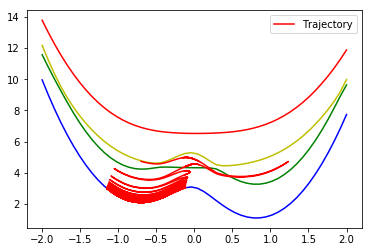

In [19]:
### density matrix
D = np.zeros((4,4),dtype=complex)
D[2,2] = 1.+0j
### Hamiltonian matrix
for i in range(0,N_time):
    #### Update nuclear coordinate first
    time[i] = i*dt
    res = Erhenfest(ri, vi, M, D, Hp, Hep, He, gamma, gam_deph, dr, dt)
    #res = VelocityVerlet(Fg_spline, Fe_spline, np.real(D[0,0]), np.real(D[1,1]), M, ri, vi, dt)
    ri = res[0]
    vi = res[1]
    r_of_t[i] = ri
    v_of_t[i] = vi
    D = res[2]
    Htot = H_e(He, ri) + Hp + Hep
    e_of_t[i] = TrHD(Htot, D)
    for j in range(0,4):
        p_of_t[i,j] = np.real(D[j,j])

    
plt.plot(rlist, 27.211*PPES[:,0], 'b')
plt.plot(rlist, 27.211*PPES[:,1], 'g')
plt.plot(rlist, 27.211*PPES[:,2], 'y')
plt.plot(rlist, 27.211*PPES[:,3], 'r')
plt.plot(r_of_t, 27.211*e_of_t, 'red', label='Trajectory')
plt.legend()
plt.show()

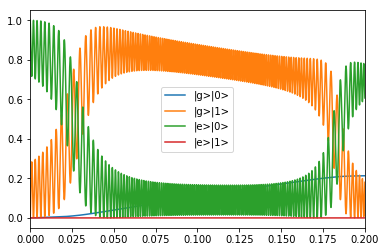

In [20]:
au_to_ps = 2.418e-5
plt.plot(time*au_to_ps, p_of_t[:,0], label='|g>|0>')
plt.plot(time*au_to_ps, p_of_t[:,1], label='|g>|1>')
plt.plot(time*au_to_ps, p_of_t[:,2], label='|e>|0>')
plt.plot(time*au_to_ps, p_of_t[:,3], label='|e>|1>')
plt.legend()
plt.xlim(0,0.2)
plt.show()


#plt.plot(rlist, 27.211*PPES[:,0], 'b')
#plt.plot(rlist, 27.211*PPES[:,1], 'g')
#plt.plot(rlist, 27.211*PPES[:,2], 'y')
#plt.plot(rlist, 27.211*PPES[:,3], 'r')
#plt.plot(r_of_t, 27.211*e_of_t, 'red', label='Trajectory')
#plt.legend()
#plt.show()

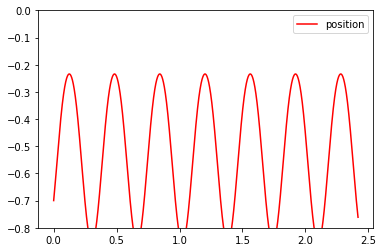

In [61]:
### polariton dynamics!
M = 1009883
ri = -0.7
vi = 0.00012*100
dt = 1.
c_g = np.sqrt(4/9)
c_e = np.sqrt(5/9)
N_time = 50000*2
time = np.zeros(N_time)
v_of_t = np.zeros(N_time)
r_of_t = np.zeros(N_time)

for i in range(0,N_time):
    time[i] = i*dt
    res = VelocityVerlet(FLP_spline, FUP_spline, c_g, c_e, M, ri, vi, dt)
    ri = res[0]
    vi = res[1]
    r_of_t[i] = ri
    v_of_t[i] = vi
au_to_ps = 2.418e-5
plt.plot(time*au_to_ps, r_of_t, 'red', label='position')
plt.ylim(-0.8,0)
plt.legend()
plt.show()

[[0.         0.         0.         0.00499798 0.         0.        ]
 [0.         0.         0.         0.00499798 0.         0.        ]
 [0.         0.         0.         0.         0.00499798 0.00499798]
 [0.00499798 0.00499798 0.         0.         0.         0.        ]
 [0.         0.         0.00499798 0.         0.         0.        ]
 [0.         0.         0.00499798 0.         0.         0.        ]]


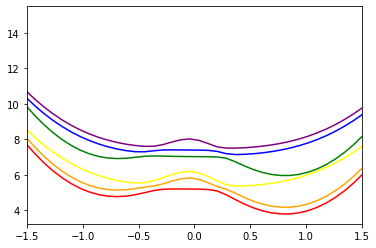

In [62]:
om1 = (2.18)/27.211 
om2 = (1.8)/27.211
### hbar g_c in atomic units
g1 = 0.136/27.211
g2 = 0.136/27.211
#g1 = 0.1/27.211
#g2 = 0.1/27.211
#g1 = 0
#g2 = 0
### form empty arrays for lower and upper polariton surface
P1 = np.zeros_like(rlist)
P2 = np.zeros_like(rlist)
P3 = np.zeros_like(rlist)
P4 = np.zeros_like(rlist)
P5 = np.zeros_like(rlist)
P6 = np.zeros_like(rlist)

Ht = np.zeros((6,6))

### Coupling for 2-mode light system couples <g| to |e> and either: 
Vec1 = np.zeros((6,3))
Vec1[0,:] = [1,0,0]
Vec1[1,:] = [0,1,0]
Vec1[2,:] = [1,1,0]
Vec1[3,:] = [0,0,1]
Vec1[4,:] = [1,0,1]
Vec1[5,:] = [0,1,1]

for i in range(0,6):
    for j in range(0,6):
        bra = Vec1[i,:]
        ket = Vec1[j,:]
        
        ### first see if we are coupling <g| to |e> or vice versa
        if bra[2] != ket[2]:
            if ((bra[0] != ket[0]) and (bra[1] == ket[1])):
                Ht[i,j] = g1
            elif ((bra[1] != ket[1]) and (bra[0] == ket[0])):
                Ht[i,j] = g2
print(Ht)
                  

for i in range(0,len(rlist)):
    r = rlist[i]
    PES = E_of_R(r)
    for j in range(0,6):
        ket = Vec1[j,:]
        Ht[j,j] = (ket[0]+1/2)*om1 + (ket[1]+1/2)*om2 + PES[int(ket[2])]
        tmpH = np.copy(Ht)
        vals, vecs = LA.eig(Ht)
        idx = vals.argsort()[::1]
        vals = vals[idx]
        P1[i] = vals[0]
        P2[i] = vals[1]
        P3[i] = vals[2]
        P4[i] = vals[3]
        P5[i] = vals[4]
        P6[i] = vals[5]

        
plt.plot(rlist, 27.211*P1, 'red')
plt.plot(rlist, 27.211*P2, 'orange')
plt.plot(rlist, 27.211*P3, 'yellow')
plt.plot(rlist, 27.211*P4, 'green')
plt.plot(rlist, 27.211*P5, 'blue')
plt.plot(rlist, 27.211*P6, 'purple')
### form spline for LP surface
UP2_spline = InterpolatedUnivariateSpline(rlist, P6, k=3)
FUP2_spline = UP2_spline.derivative()

### form spline for excited-state surface
LP2_spline = InterpolatedUnivariateSpline(rlist, P5, k=3)
FLP2_spline = LP2_spline.derivative()
plt.xlim(-1.5,1.5)
#plt.ylim(2,5.5)
plt.show()



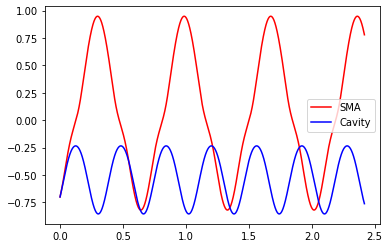

In [63]:
v2_of_t = np.zeros(N_time)
r2_of_t = np.zeros(N_time)
ri = -0.7
vi = 0.00012
for i in range(0,N_time):
    time[i] = i*dt
    res = VelocityVerlet(FLP2_spline, FUP2_spline, c_g, c_e, M, ri, vi, dt)
    ri = res[0]
    vi = res[1]
    r2_of_t[i] = ri
    v2_of_t[i] = vi
au_to_ps = 2.418e-5
plt.plot(time*au_to_ps, r2_of_t, 'red', label='SMA')
plt.plot(time*au_to_ps, r_of_t, 'blue', label='Cavity')
#plt.ylim(-0.8,0)
plt.legend()
plt.show()